In [ ]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
import numpy as np
import random
from collections import deque
import pickle
import matplotlib.pyplot as plt
# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Activation, Flatten, Conv2D, MaxPooling2D
# from tensorflow.keras.optimizers import Adam

In [ ]:
!pip install gym[atari,accept-rom-license]==0.21.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.5 MB 28.5 MB/s 
     |████████████████████████████████| 1.6 MB 53.6 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for gym: filename=gym-0.21.0-py3-none-any.whl size=1616822 sha256=fde917063c8938d07fabcd1eb77e37ab95c55189fd01d4a93128bb77c1c3ddce
  Stored in directory: /root/.cache/pip/wheels/76/ee/9c/36bfe3e079df99acf5ae57f4e3464ff2771b34447d6d2f2148
  Created wheel for AutoROM.accept-rom-license: filename=AutoROM.accept_rom_license-0.4.2-py3-none-any.whl size=441028 sha256=5cc1bbb03d0fef5d3cd38361dbd81358012ad4afe1207135655a8a3531e7df6c
  Stored in directory: /root/.cache/pip/wheels/87/67/2e/6147e7912fe37f5408b80d07527dab807c1d25f5c403a9538a
Successfully built gym AutoROM.accept-rom-license
  Attempting uninstall: gym
    Found existing installati

In [ ]:
import gym
env = gym.make('CartPole-v1')

In [ ]:
from typing import Set
# Making tf as torch

import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
  def __init__(self, output):
    super(Net, self).__init__()
    self.fc1 = nn.Linear(4, 24)
    self.fc2 = nn.Linear(24, 24)
    self.fc3 = nn.Linear(24, output)
  
  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

class DQN_Torch:
    def __init__(self, state_size, action_size):
        
        #define the state size
        self.state_size = state_size
        
        #define the action size
        self.action_size = action_size
        
        #define the replay buffer
        self.replay_buffer = deque(maxlen=10000)

        #define the demo buffer
        self.demo_buffer = deque(maxlen=10000)
        
        #define the discount factor
        self.gamma = 0.9  
        
        #define the epsilon value
        self.epsilon = 0.1
        
        #define the update rate at which we want to update the target network
        self.update_rate = 100
        
        #define the main network
        self.main_network = Net(self.action_size)
        
        self.loss_fn = nn.MSELoss()
        self.loss_supervised_fn = nn.L1Loss()

        self.optim = torch.optim.Adam(self.main_network.parameters(),lr=0.001)
      
        #define the target network
        self.target_network = Net(self.action_size)
        self.target_network.requires_grad = False

        # self.device = torch.device('cpu')
        if torch.cuda.is_available:
          self.device = torch.device('cuda')
          self.main_network = self.main_network.to(device)
          self.target_network = self.target_network.to(device)
        else:
          self.device = torch.device('cpu')
        
        #copy the weights of the main network to the target network
        self.target_network.load_state_dict(self.main_network.state_dict())

    #We learned that we train DQN by randomly sampling a minibatch of transitions from the
    #replay buffer. So, we define a function called store_transition which stores the transition information
    #into the replay buffer

    def store_transistion(self, state, action, reward, next_state, done):
        self.replay_buffer.append((state, action, reward, next_state, done))
        
    # Save expert demonstrations
    def store_demonstrations(self, state, action, reward, next_state, done):
        self.demo_buffer.append((state, action, reward, next_state, done))

    #We learned that in DQN, to take care of exploration-exploitation trade off, we select action
    #using the epsilon-greedy policy. So, now we define the function called epsilon_greedy
    #for selecting action using the epsilon-greedy policy.
    
    def epsilon_greedy(self, state):
        if random.uniform(0,1) < self.epsilon:
            return np.random.randint(self.action_size)
        
        Q_values = self.main_network(torch.from_numpy(state).type(torch.float).to(device))
        
        # print(Q_values, torch.argmax(Q_values[0]).item())
        return torch.argmax(Q_values).item()

    # Pretrain using expert demonstrations
    def pre_train(self):
      print('Pre-training ...')
      for i in range(100): ## PARAM_CHECK: how many steps for pretraining?
          self.train(batch_size = 512, pretrain=True)
          if i % 10 == 0 and i > 0:
              get_demonstrations_from_trained_dqn(self.main_network.state_dict())
              print('{}th step of pre-train finish ...'.format(i))
      print('All pre-train finish.')

    
    # Supervised Loss function for the demo buffer data

    def loss_supervised(self, X, y):
        X_max, _ = torch.max(X, axis=1)
        # print(X_max, y)
        return self.loss_supervised_fn(X_max, y)


    #train the network
    def train(self, batch_size = 32, pretrain = False, sample_demo = False, demo_sample_percent = 0.25, supervised_weight = 1.0):
        
        data_buffer = []
        demo_buffer = []

        # # data_buffer = self.demo_buffer if pretrain else self.replay_buffer
        if pretrain:
          #sample a mini batch of transition from the demo buffer if pretrain
          demo_buffer = random.sample(self.demo_buffer, batch_size)
        elif sample_demo:
          ## Add some of the expert_demos to the replay_buffer
          demo_sample_size = int(batch_size * demo_sample_percent)
          demo_buffer = random.sample(self.demo_buffer, demo_sample_size)
          data_buffer = random.sample(self.replay_buffer, batch_size - demo_sample_size)
          # print(f'Demos: {len(self.demo_buffer)}, Data: {len(data_buffer)}') 
        else:
          ## Don't include any expert demonstrations during training
          data_buffer = random.sample(self.replay_buffer, batch_size)
          
        # minibatch = random.sample(self.replay_buffer, batch_size)
        # minibatch = random.sample(data_buffer, batch_size)

        minibatch = []
        if(len(data_buffer)!=0):
          minibatch.append(data_buffer)
        if(len(demo_buffer)!= 0):
          minibatch.append(demo_buffer)
        minibatch = np.concatenate(minibatch, axis=0)

        X = [] # State 
        y = [] # Expected Q values of the input state
        
        #compute the Q value using the target network 
        for state, action, reward, next_state, done in minibatch:
            if not done:
                target_Q = (reward + self.gamma * torch.max(self.target_network(torch.from_numpy(next_state).type(torch.float).to(device))).detach().cpu().numpy())
            else:
                target_Q = reward
                
            #compute the Q value using the main network
            state = torch.from_numpy(state).type(torch.float).to(self.device) 
            Q_values = self.main_network(state)

            # print(Q_values)
            Q_values[action] = target_Q
            # print(Q_values)
            X.append(state)
            y.append(Q_values)
        
        X = torch.squeeze(torch.stack(X, 0), 1)
        y = torch.squeeze(torch.stack(y, 0), 1)
        # X = torch.from_numpy(np.array(X).astype('float32')).type(torch.float).to(self.device)
        # y = torch.from_numpy(np.array(y).astype('float32')).type(torch.float).to(self.device)

        y_pred = self.main_network(X)

        X_supervised = [] # Q_value of the state with masks
        y_supervised = [] # Actual Q_value of the selected action

        for state, action, reward, next_state, done in demo_buffer:
            #compute the Q value using the main network
            state = torch.from_numpy(state).type(torch.float).to(self.device) 
            Q_values = self.main_network(state)

            mask_action = 0.8 * torch.ones(self.action_size).type(torch.float).to(self.device)
            mask_action[action] = 0

            X_supervised.append(Q_values + mask_action)
            y_supervised.append(Q_values[action])
        
        if(len(demo_buffer) > 0):
          # print(X_supervised, y_supervised)
          X_supervised = torch.squeeze(torch.stack(X_supervised, 0), 1)
          y_supervised = torch.stack(y_supervised, 0).detach()

        if(len(demo_buffer) > 0):
          loss = self.loss_fn(y_pred, y) + supervised_weight * self.loss_supervised(X_supervised, y_supervised) # TODO: lambda is the weighting parameter for the supervised loss. Value = ?
        else:
          loss = self.loss_fn(y_pred, y)

        self.optim.zero_grad()
        loss.backward()
        self.optim.step()
            
    #update the target network weights by copying from the main network
    def update_target_network(self):
        self.target_network.load_state_dict(self.main_network.state_dict())

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [ ]:
num_episodes = 150
num_timesteps = 1000
batch_size = 32
num_screens = 4
state_size = 4
action_size = 2

In [ ]:
def get_demonstrations_from_trained_dqn(trained_state_dict, store=False):
  trained_dqn = DQN_Torch(state_size, action_size)
  trained_dqn.target_network.load_state_dict(trained_state_dict)
  trained_dqn.main_network.load_state_dict(trained_state_dict)
  # new_action = trained_dqn.epsilon_greedy()
  done = False
  avg_reward = 0

  for i in range(100):
      
      #set return to 0
      Return = 0
      
      #preprocess the game screen
      state = env.reset()

      #for each step in the episode
      for t in range(1000):

          action = trained_dqn.epsilon_greedy(state)

          #perform the selected action
          next_state, reward, done, _ = env.step(action)

          #store the transition information
          trained_dqn.store_transistion(state, action, reward, next_state, done)

          #update current state to next state
          state = next_state

          #update the return
          Return += reward

          if done:
            # print(f"Iteration {i}: Time Steps Completed: {t}")
            avg_reward += Return
            break

  print(f"Total Avg Reward = {avg_reward/100}")
  # print(trained_dqn.replay_buffer)
  if store:
    pickle.dump(trained_dqn.replay_buffer, open('drive/MyDrive/CS7648_group7_project/project/Sai_folder/code/demo_data/expert_demonstrations', 'wb'))

In [ ]:
trained_state_dict = pickle.load(open('drive/MyDrive/CS7648_group7_project/project/Sai_folder/code/model_weights/model_weights_100.pkl', 'rb'))
get_demonstrations_from_trained_dqn(trained_state_dict, store=True)

Total Avg Reward = 129.04


In [ ]:
def run_DDQN(dqn):

  done = False
  time_step = 0
  ep_reward = []
  ep_steps = []

  #for each episode
  for i in range(num_episodes):
      
      #set return to 0
      Return = 0
      
      #preprocess the game screen
      state = env.reset()

      #for each step in the episode
      for t in range(num_timesteps):
          #render the environment
          # env.render(render_mode = "human")
          
          #update the time step
          time_step += 1
          
          #update the target network
          if time_step % dqn.update_rate == 0:
              dqn.update_target_network()

          #select the action
          action = dqn.epsilon_greedy(state)

          #perform the selected action
          next_state, reward, done, _ = env.step(action)

          #store the transition information
          dqn.store_transistion(state, action, reward, next_state, done)

          #update current state to next state
          state = next_state

          #update the return
          Return += reward

          # if t%1000 == 0:
          #   print(f"Episode: {i}  TimeStep: {t}  Cum Reward: {Return}")

          #if the episode is done then print the return
          if done:
              print(f"Episode: {i} Time Step: {t} Cumulative Rewards: {Return}")
              ep_reward.append(Return)
              ep_steps.append(t)
              break
              
          #if the number of transistions in the replay buffer is greater than batch size
          #then train the network
          if len(dqn.replay_buffer) > batch_size:
              dqn.train(batch_size)

  return ep_reward

In [ ]:
def run_DQfD(dqn):
  # dqn = DQN_Torch(state_size, action_size)

  # ## Pre-train the network on the expert demonstration

  # # get the demonstrations (Assuming there is a file)
  expert_demos = pickle.load(open('drive/MyDrive/CS7648_group7_project/project/Sai_folder/code/demo_data/expert_demonstrations', 'rb')) ## TODO: Get the demos from file
  # for demo in expert_demos:
  #   dqn.store_demonstrations(demo)

  dqn.demo_buffer = expert_demos

  print(f"Number of <state,action> pairs in the demonstrator data = {len(expert_demos)}")

  # ## Add some of the expert_demos in the replay_buffer
  # demo_sample_size = len(dqn.demo_buffer)//4
  # dqn.replay_buffer = random.sample(dqn.demo_buffer, demo_sample_size) 

  ## Pre-train the network
  dqn.pre_train()

  done = False
  time_step = 0
  ep_reward = []
  ep_steps = []

  #for each episode
  for i in range(num_episodes):
      
      #set return to 0
      Return = 0
      
      #preprocess the game screen
      state = env.reset()

      #for each step in the episode
      for t in range(num_timesteps):
          #render the environment
          # env.render(render_mode = "human")
          
          #update the time step
          time_step += 1
          
          #update the target network
          if time_step % dqn.update_rate == 0:
              dqn.update_target_network()

          #select the action
          action = dqn.epsilon_greedy(state)

          #perform the selected action
          next_state, reward, done, _ = env.step(action)

          #store the transition information
          dqn.store_transistion(state, action, reward, next_state, done)

          #update current state to next state
          state = next_state

          #update the return
          Return += reward

          # if t%1000 == 0:
          #   print(f"Episode: {i}  TimeStep: {t}  Cum Reward: {Return}")

          #if the episode is done then print the return
          if done:
              print(f"Episode: {i} Time Step: {t} Cumulative Rewards: {Return}")
              ep_reward.append(Return)
              ep_steps.append(t)
              break
              
          #if the number of transistions in the replay buffer is greater than batch size
          #then train the network
          if len(dqn.replay_buffer) > batch_size:
              dqn.train(batch_size, sample_demo = True, supervised_weight = 1.0/(i+1))
    
      if(len(ep_reward) > 10 and np.mean(ep_reward[-10:0])==500):
        break

  return ep_reward

In [ ]:
def plot_rewards(ep_reward):
  plt.plot(np.arange(len(ep_reward)), ep_reward)
  plt.show()

In [ ]:
ep_reward_ddqn = run_DDQN(DQN_Torch(state_size, action_size))

Episode: 0 Time Step: 9 Cumulative Rewards: 10.0
Episode: 1 Time Step: 9 Cumulative Rewards: 10.0
Episode: 2 Time Step: 10 Cumulative Rewards: 11.0
Episode: 3 Time Step: 8 Cumulative Rewards: 9.0
Episode: 4 Time Step: 9 Cumulative Rewards: 10.0
Episode: 5 Time Step: 8 Cumulative Rewards: 9.0
Episode: 6 Time Step: 11 Cumulative Rewards: 12.0
Episode: 7 Time Step: 8 Cumulative Rewards: 9.0
Episode: 8 Time Step: 9 Cumulative Rewards: 10.0
Episode: 9 Time Step: 7 Cumulative Rewards: 8.0
Episode: 10 Time Step: 8 Cumulative Rewards: 9.0
Episode: 11 Time Step: 8 Cumulative Rewards: 9.0
Episode: 12 Time Step: 9 Cumulative Rewards: 10.0
Episode: 13 Time Step: 7 Cumulative Rewards: 8.0
Episode: 14 Time Step: 8 Cumulative Rewards: 9.0
Episode: 15 Time Step: 9 Cumulative Rewards: 10.0
Episode: 16 Time Step: 11 Cumulative Rewards: 12.0
Episode: 17 Time Step: 9 Cumulative Rewards: 10.0
Episode: 18 Time Step: 9 Cumulative Rewards: 10.0
Episode: 19 Time Step: 8 Cumulative Rewards: 9.0
Episode: 20 Time

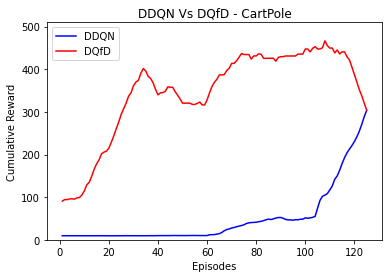

In [ ]:
k = 25
avg = [np.mean(ep_reward_ddqn[i:i+k]) for i in range(0, len(ep_reward_ddqn)-k)]
avg1 = [np.mean(ep_reward_dqfd[i:i+k]) for i in range(0, len(ep_reward_dqfd)-k)]
plt.plot(np.arange(1, len(avg)+1), avg, c='b', label='DDQN')
plt.plot(np.arange(1, len(avg)+1), avg1, c='r', label='DQfD')
plt.ylim(0,510)
plt.title('DDQN Vs DQfD - CartPole')
plt.xlabel('Episodes')
plt.ylabel('Cumulative Reward')
plt.legend()
plt.show()

In [ ]:
dqn = DQN_Torch(state_size, action_size)
ep_reward_dqfd = run_DQfD(dqn)

Number of <state,action> pairs in the demonstrator data = 10000
Pre-training ...


<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


Total Avg Reward = 50.98
10th step of pre-train finish ...
Total Avg Reward = 86.8
20th step of pre-train finish ...
Total Avg Reward = 64.74
30th step of pre-train finish ...
Total Avg Reward = 59.91
40th step of pre-train finish ...
Total Avg Reward = 59.24
50th step of pre-train finish ...
Total Avg Reward = 60.21
60th step of pre-train finish ...
Total Avg Reward = 66.92
70th step of pre-train finish ...
Total Avg Reward = 70.89
80th step of pre-train finish ...
Total Avg Reward = 82.71
90th step of pre-train finish ...
All pre-train finish.
Episode: 0 Time Step: 85 Cumulative Rewards: 86.0
Episode: 1 Time Step: 97 Cumulative Rewards: 98.0
Episode: 2 Time Step: 42 Cumulative Rewards: 43.0
Episode: 3 Time Step: 85 Cumulative Rewards: 86.0
Episode: 4 Time Step: 103 Cumulative Rewards: 104.0
Episode: 5 Time Step: 53 Cumulative Rewards: 54.0
Episode: 6 Time Step: 53 Cumulative Rewards: 54.0
Episode: 7 Time Step: 83 Cumulative Rewards: 84.0
Episode: 8 Time Step: 89 Cumulative Rewards: 9

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Episode: 11 Time Step: 136 Cumulative Rewards: 137.0
Episode: 12 Time Step: 92 Cumulative Rewards: 93.0
Episode: 13 Time Step: 62 Cumulative Rewards: 63.0
Episode: 14 Time Step: 144 Cumulative Rewards: 145.0
Episode: 15 Time Step: 79 Cumulative Rewards: 80.0
Episode: 16 Time Step: 83 Cumulative Rewards: 84.0
Episode: 17 Time Step: 51 Cumulative Rewards: 52.0
Episode: 18 Time Step: 56 Cumulative Rewards: 57.0
Episode: 19 Time Step: 154 Cumulative Rewards: 155.0
Episode: 20 Time Step: 129 Cumulative Rewards: 130.0
Episode: 21 Time Step: 76 Cumulative Rewards: 77.0
Episode: 22 Time Step: 111 Cumulative Rewards: 112.0
Episode: 23 Time Step: 55 Cumulative Rewards: 56.0
Episode: 24 Time Step: 166 Cumulative Rewards: 167.0
Episode: 25 Time Step: 178 Cumulative Rewards: 179.0
Episode: 26 Time Step: 91 Cumulative Rewards: 92.0
Episode: 27 Time Step: 89 Cumulative Rewards: 90.0
Episode: 28 Time Step: 89 Cumulative Rewards: 90.0
Episode: 29 Time Step: 86 Cumulative Rewards: 87.0
Episode: 30 Time 

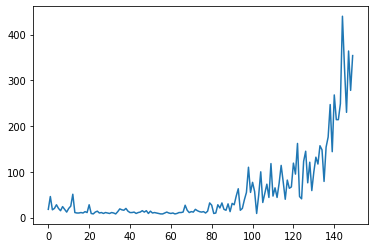

In [ ]:
avg_dqfd_rewards = [np.mean(ep_reward_dqfd[i:i+20]) for i in range(0, len(ep_reward_dqfd)-20)]
plot_rewards(avg_reward_dqfd)

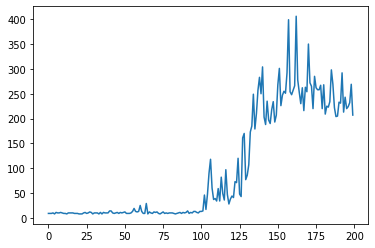

In [ ]:
# import matplotlib.pyplot as plt
# plt.plot(np.arange(len(ep_reward)), ep_reward)
# plt.show()